In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle,Circle

from quantum import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Set up system

In [3]:
s = 1/2
M = int(2*s+1)

N = 16
n = M**N

N_S = 2
N_B = N - N_S

S_idx = [0,1]
B_idx = np.setdiff1d(np.arange(N),S_idx)

In [4]:
J = 1
hs = np.linspace(0,2.5,501)
                
θs = np.arctan(1/hs)
α = 1,
βs = 1/np.logspace(-2.5,2,100)

<ipython-input-4-e7d201059ed9>:4: RuntimeWarning: divide by zero encountered in true_divide
  θs = np.arctan(1/hs)


In [5]:
n_ave = 500
k = 60

EVs = np.zeros((len(θs),len(βs),M**N_S))
GSEVs = np.zeros((len(θs),M**N_S))

In [6]:
idxs = [1,50,100,150,200,250,300,350,400,450]
idxs += list(set(range(10,450,10)).difference(set(idxs)))
idxs += [75,145,185,215,245,255,265,275,65,72,135,142,188,218,225,235,242,248,252,258,262,268,272,278,285,295,305,315,325,335,345,355,365,375,385,395,5,15,25,35,45,55,65,85,95,105,115,125,155,165,175,195,205,225,235]

idxs = np.array(idxs,dtype='int')

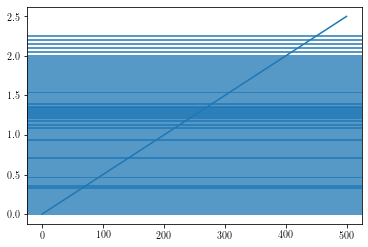

In [7]:
plt.plot(hs)
for q in idxs:
    plt.axhline(hs[q])

In [26]:
for q in idxs:
    θ = θs[q]

    h = np.cos(θ)/np.sin(θ)*J

    Jz_T = h*np.ones(N)
    J_T = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                J_T[i,j] = 1/np.abs(i-j)**α

    J_B,J_S,J_I,Jz_B,Jz_S,Jz_I = get_connection_matrix(J_T,Jz_T,N_S)

    H_S_iso = get_hamiltonian(J_S[:N_S,:N_S],J_S[:N_S,:N_S],Jz_S[:N_S],s).tosparse()
    H_B_iso = get_hamiltonian(J_B[N_S:,N_S:],J_B[N_S:,N_S:],Jz_B[N_S:],s).tosparse()
    H_I = get_hamiltonian(J_I,J_I,Jz_I,s).tosparse()

    H_S = sp.sparse.kron(H_S_iso,sp.sparse.eye((2*s+1)**N_B)).tocsr()
    H_B = sp.sparse.kron(sp.sparse.eye((2*s+1)**N_S),H_B_iso).tocsr()
    H_T = H_S + H_B + H_I


    E0,ψ0 = sp.sparse.linalg.eigsh(H_T,1,which='SA')#,v0=(ψ0 if q>0 else None))
    ρ0 = np.zeros((M**N_S,M**N_S))
    for m in range(M**N_S):
        for n in range(M**N_S):
            ρ0[m,n] = (ψ0[m*M**N_B:(m+1)*M**N_B].conj().T@ψ0[n*M**N_B:(n+1)*M**N_B])[0,0]

    try:
        GSEVs[q] = np.linalg.eigvalsh(ρ0)
    except:
        pass 

    clear_output(wait=True)
    print(f'θ:{q}/{len(θs)}')

    s_print = 5
    trB_expH_T,tr_expH_B,trB_H_I = get_partial_traces(H_T,H_I,H_B_iso,βs,k,n_ave,M,N,N_S,N_B,E0,s_print)

    for l,β in enumerate(βs):
        try:
            EVs[q,l] = np.linalg.eigvalsh(trB_expH_T[l]/tr_expH_B[l])
        except:
            pass 

    np.save(f'data/EVs_{N}_{k}_{n_ave}_{q}',[EVs[q],GSEVs[q],θs,βs])

θ:235/501
